In [96]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


### Dataset: VHM Historical Data



In [97]:
df = pd.read_csv('../Datasets/1 - VHM Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df


,Price
Date,
2019-03-01,68421.0
2019-03-04,70075.0
2019-03-05,68421.0
2019-03-06,69022.0
2019-03-07,69173.0
...,...
2024-05-27,39800.0
2024-05-28,39950.0
2024-05-29,39450.0


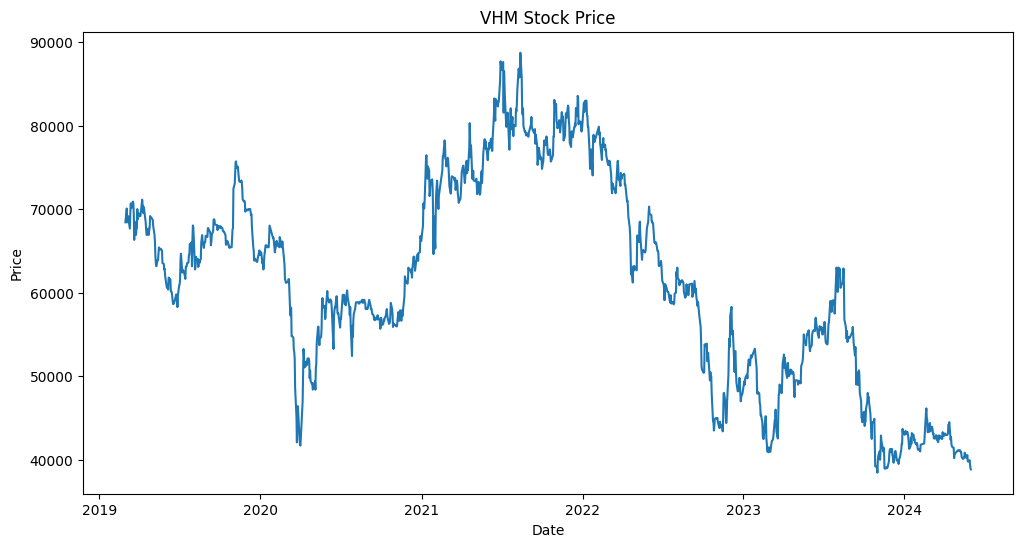

In [98]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['Price'])
plt.title('VHM Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [99]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

#### Ratio 7:3

In [100]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(0.3 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

In [101]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [102]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [103]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [104]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [105]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.2151
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0190
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0113
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0072
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0058
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0052
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0043
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0043
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0044
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0040
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0039
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0041
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0039
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0040
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - lo

In [106]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [107]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [108]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 48827.32452019172
Testing MAPE: 6.531963067483931e+17
Testing MAE: 48477.00144789987


In [109]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

lst_output = []
n_steps = 100
i = 0

while (i < 30):
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[-n_steps:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

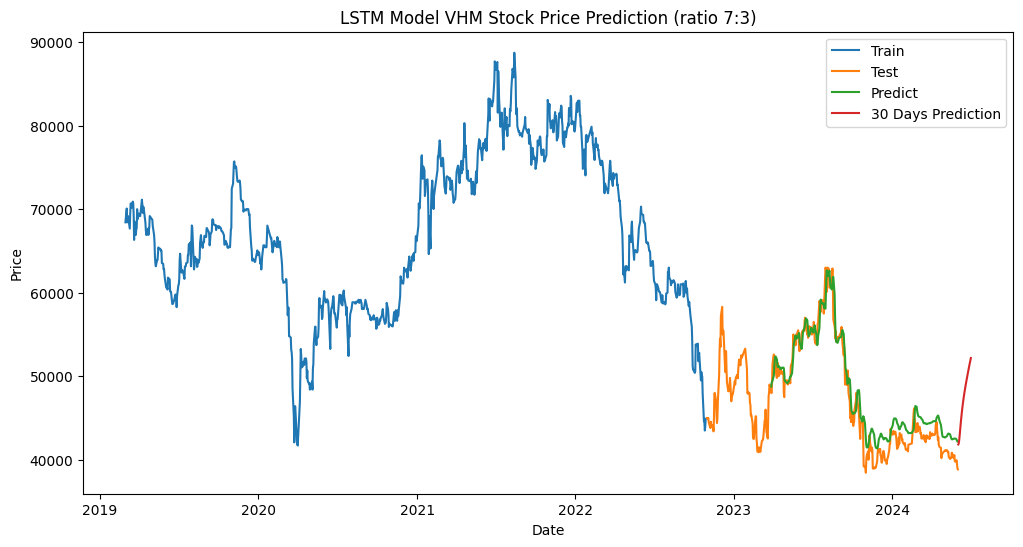

In [110]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('LSTM Model VHM Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Ratio 8:2

In [111]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(0.2 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

In [112]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [113]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [114]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [115]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [116]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 0.1984
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.0206
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0082
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0061
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0048
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0050
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0049
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0042
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0044
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0044
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0041
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0039
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0040
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0036
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/ste

In [117]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [118]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [119]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 42944.8575022051
Testing MAPE: 1.1186714730665851e+18
Testing MAE: 42917.33821962229


In [120]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

lst_output = []
n_steps = 100
i = 0

while (i < 30):
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[-n_steps:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

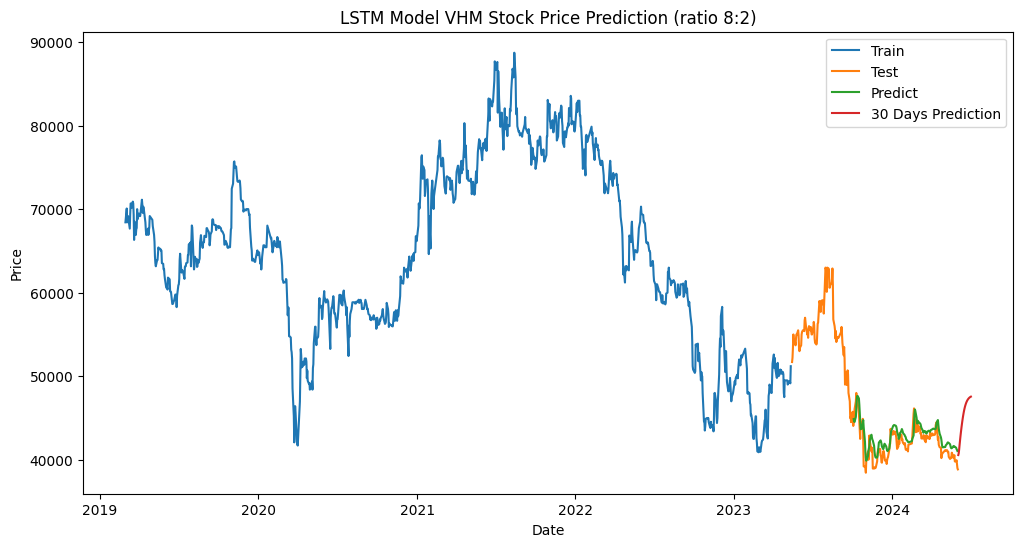

In [121]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('LSTM Model VHM Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Radio 9:1

In [122]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(0.1 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

In [123]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [124]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [125]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [126]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [127]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0898
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0087
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0055
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0046
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0047
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0044
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0044
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0040
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0040
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0038
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0040
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0035
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0037
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0036
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/ste

In [128]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [129]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [130]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 41063.27005560195
Testing MAPE: 1090201.1489112247
Testing MAE: 41052.50372614643


In [131]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

lst_output = []
n_steps = 100
i = 0

while (i < 30):
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[-n_steps:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

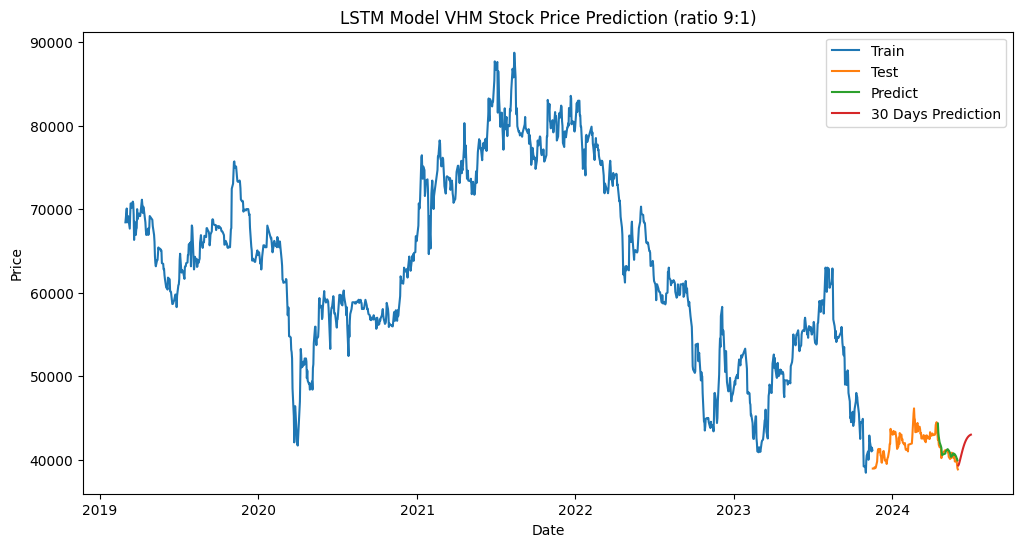

In [132]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('LSTM Model VHM Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

### Dataset: NVL Historical Data


In [134]:
df = pd.read_csv('../Datasets/2 - NVL Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df


,Price
Date,
2019-03-01,32933.0
2019-03-04,33100.0
2019-03-05,32711.0
2019-03-06,31709.0
2019-03-07,31932.0
...,...
2024-05-27,14500.0
2024-05-28,14500.0
2024-05-29,14150.0


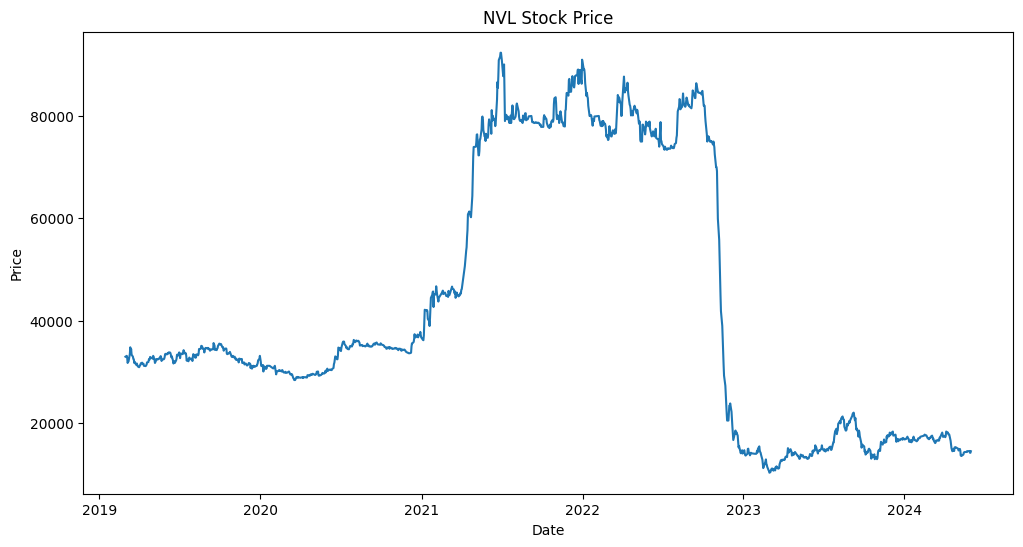

In [135]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['Price'])
plt.title('NVL Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [136]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

#### Ratio 7:3

In [137]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(0.3 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

In [138]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [139]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [140]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [141]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [142]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.1949
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0193
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0052
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0033
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0027
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0025
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0019
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0018
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0019
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0018
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0020
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0017
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0021
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0021
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - lo

In [143]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [144]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [145]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 14131.777293201674
Testing MAPE: 215972.63009289923
Testing MAE: 13916.367898548255


In [146]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

lst_output = []
n_steps = 100
i = 0

while (i < 30):
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[-n_steps:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

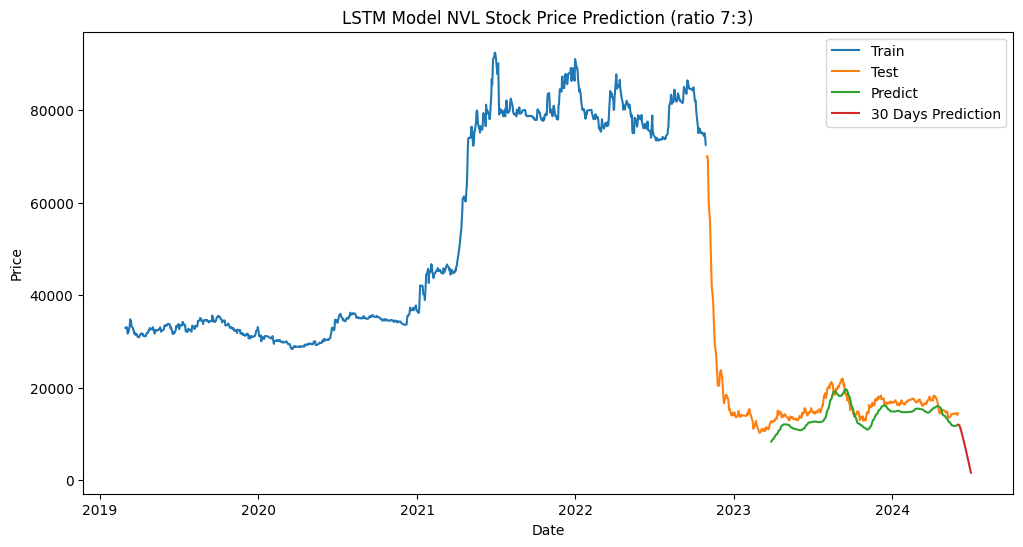

In [147]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('LSTM Model NVL Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Ratio 8:2

In [148]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(0.2 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

In [149]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [150]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [151]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [152]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [153]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.2010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0233
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0077
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0048
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0036
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0035
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0030
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0022
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0029
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0025
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0020
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0017
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0016
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0019
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - lo

In [154]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [155]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [156]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 15585.092213759857
Testing MAPE: 231848.997108821
Testing MAE: 15526.7299964261


In [157]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

lst_output = []
n_steps = 100
i = 0

while (i < 30):
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[-n_steps:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

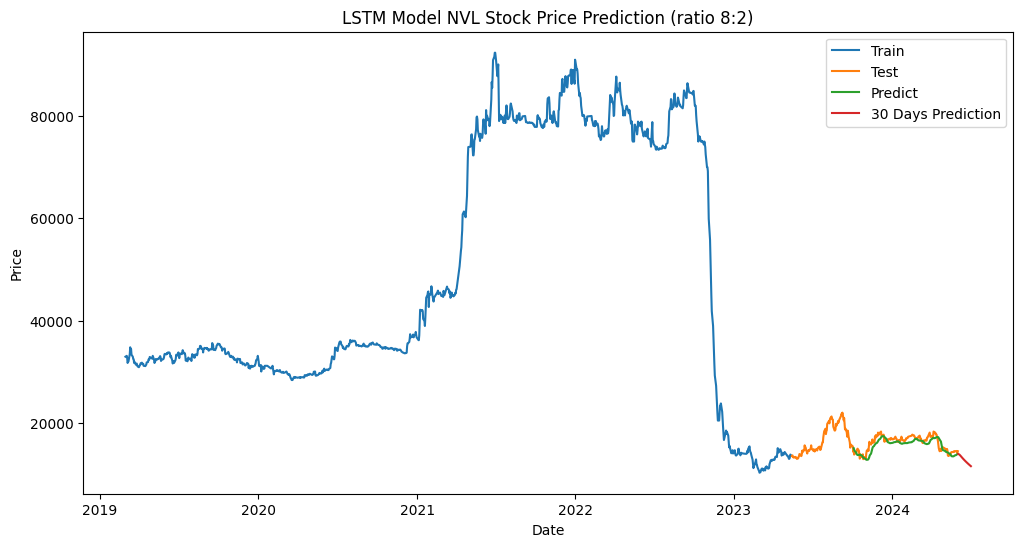

In [158]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('LSTM Model NVL Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Radio 9:1

In [159]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(0.1 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

In [160]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [161]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [162]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [163]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [164]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 0.1141
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0093
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0036
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 0.0031
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0032
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.0024
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0025
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0020
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.0017
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0019
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0017
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0016
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0015
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0014
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 12

In [165]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [166]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [167]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 15200.046258885515
Testing MAPE: 293792.9975403992
Testing MAE: 15152.774852420724


In [168]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

lst_output = []
n_steps = 100
i = 0

while (i < 30):
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[-n_steps:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

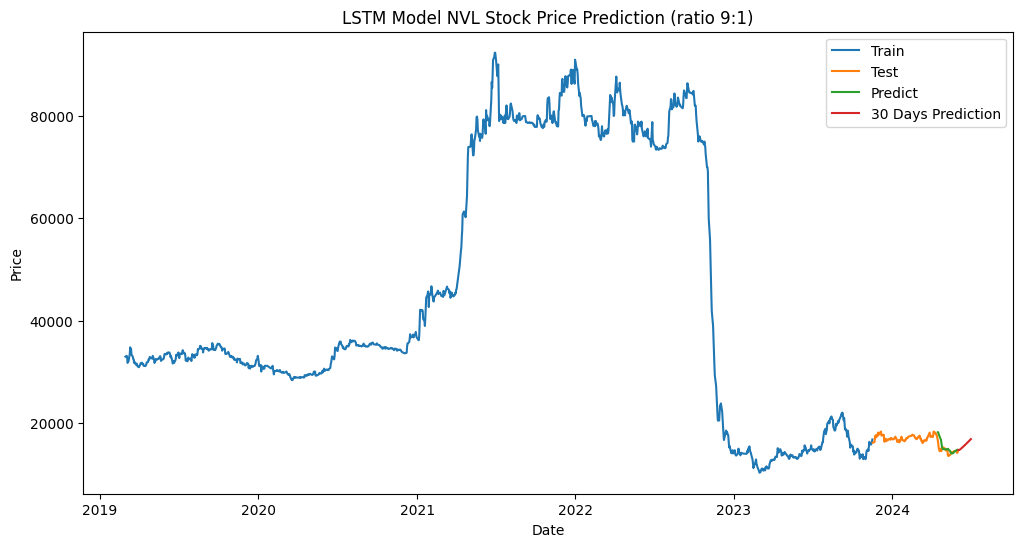

In [169]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('LSTM Model NVL Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

### Dataset: NLG Historical Data


In [170]:
df = pd.read_csv('../Datasets/3 - NLG Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df


,Price
Date,
2019-03-01,18706.8
2019-03-04,19127.2
2019-03-05,18917.0
2019-03-06,18846.9
2019-03-07,18706.8
...,...
2024-05-27,43900.0
2024-05-28,43701.0
2024-05-29,44400.0


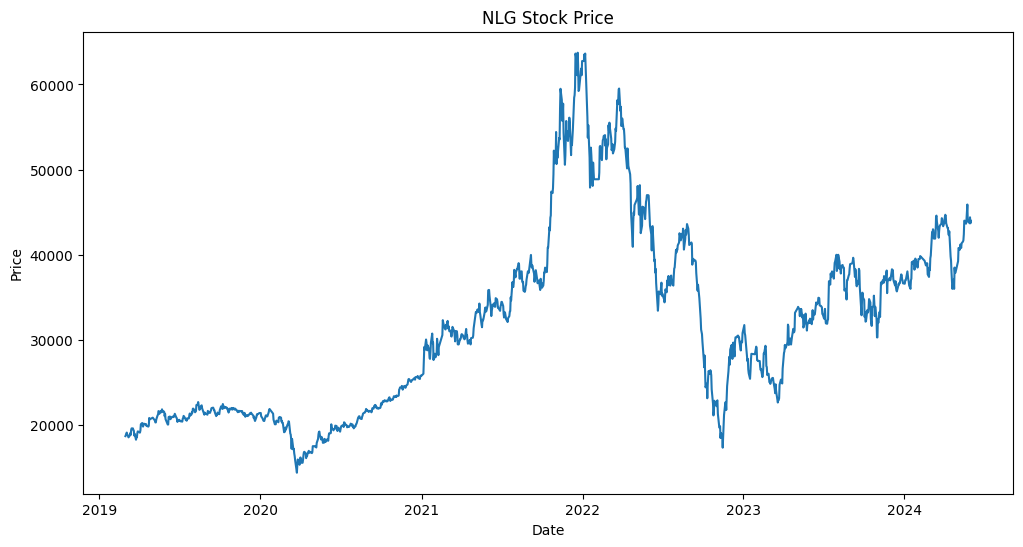

In [171]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['Price'])
plt.title('NLG Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [172]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

#### Ratio 7:3

In [173]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(0.3 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

In [174]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [175]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [176]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [177]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [178]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.1035
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0171
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0080
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0041
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0045
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0037
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0033
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0028
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0026
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0029
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0022
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0023
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0020
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0021
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/st

In [179]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [180]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [181]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 37602.15390486604
Testing MAPE: 83898.27658687725
Testing MAE: 37332.41494684267


In [182]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

lst_output = []
n_steps = 100
i = 0

while (i < 30):
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[-n_steps:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

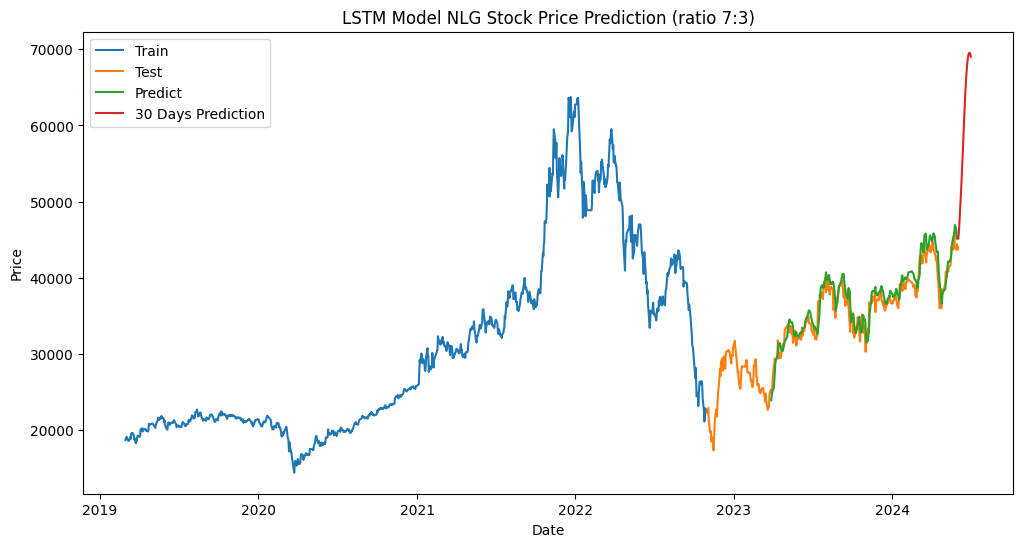

In [183]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('LSTM Model NLG Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Ratio 8:2

In [184]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(0.2 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

In [185]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [186]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [187]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [188]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [189]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0670
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0132
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0053
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0036
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0036
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0034
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0029
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0031
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0028
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0029
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0025
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0022
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0023
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0021
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step 

In [190]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [191]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [192]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 39677.10406910053
Testing MAPE: 81124.43371552262
Testing MAE: 39492.856214263054


In [193]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

lst_output = []
n_steps = 100
i = 0

while (i < 30):
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[-n_steps:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

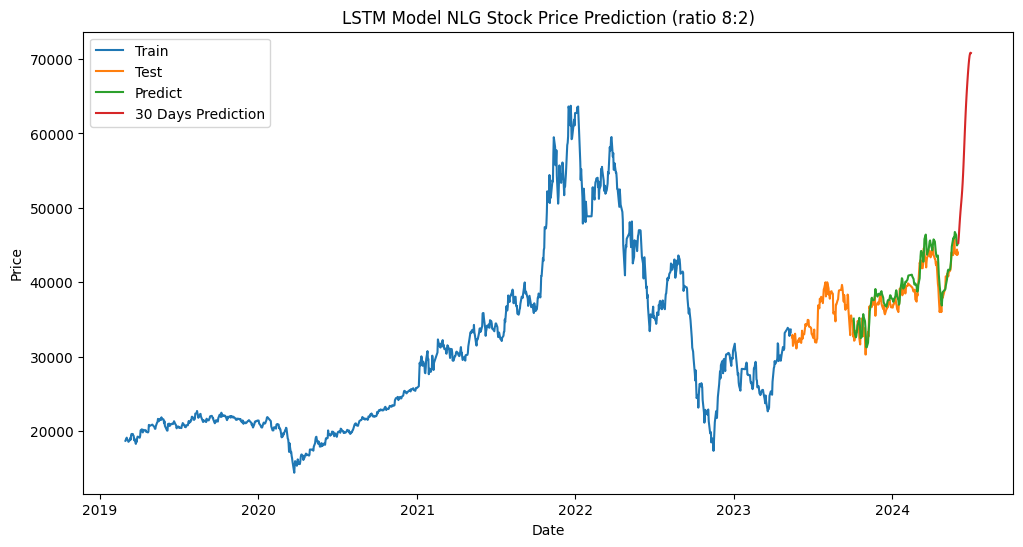

In [194]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('LSTM Model NLG Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Radio 9:1

In [195]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(0.1 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

In [196]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [197]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [198]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [199]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\minhc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [200]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.0514
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0051
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0037
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0032
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0036
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0029
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0030
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0024
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0024
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0021
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0023
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0020
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0019
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0020
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - 

In [201]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [202]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [203]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 41834.777917403844
Testing MAPE: 77032.41628473165
Testing MAE: 41739.2176040931


In [204]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

lst_output = []
n_steps = 100
i = 0

while (i < 30):
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[-n_steps:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

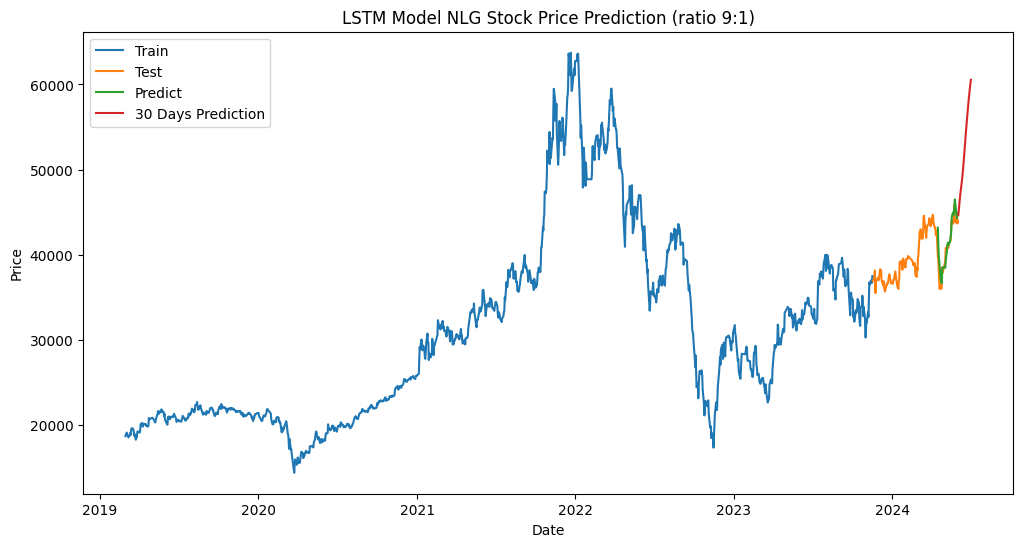

In [205]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('LSTM Model NLG Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()